In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class iResNet(nn.Module):
    def __init__(self, input_shape, full_connect_shape, q, N):
        super(iResNet, self).__init__()
        self.input_shape = input_shape
        self.full_connect_shape = full_connect_shape  # 格式：(Channel, H, W)
        self.q = q
        self.N = N

        # 从 full_connect_shape 提取通道数 C
        self.C, self.H, self.W = full_connect_shape

        # 全连接层：将输入扩展到 (C * H * W)
        self.fc = nn.Linear(np.prod(input_shape), np.prod(full_connect_shape))

        # 创建 q 个 BB
        self.bb_layers = nn.ModuleList()
        for _ in range(q):
            sb_layers = nn.ModuleList()
            for _ in range(N):
                # 动态设置 in_channels 和 out_channels 为 C
                sb_layers.append(nn.Conv2d(self.C, self.C, kernel_size=(1,3), stride=1, padding=(0,1)))
                sb_layers.append(nn.LeakyReLU(0.01))
            self.bb_layers.append(sb_layers)

        # 最后一层：输出通道数为 1
        self.final_conv = nn.Conv2d(self.C, 1, kernel_size=(1,3), stride=1, padding=(0,1))


    def forward(self, x):
        # 全连接层 + Reshape
        x = self.fc(x)
        x = x.view(-1, self.C, self.H, self.W)  # 调整为 (batch_size, C, H, W)

        # 处理每个 BB
        for sb_layers in self.bb_layers:
            bb_input = x
            for layer in sb_layers:
                x = layer(x)
            x = (bb_input + x) * 2

        # 最后一层
        T = self.final_conv(x)
        return T

In [3]:
# 初始化模型
model = iResNet(input_shape=(1,), full_connect_shape=(128, 1, 128), q=2, N=3)

# 加载训练好的权重
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

# 将模型设置为评估模式
model.eval()

iResNet(
  (fc): Linear(in_features=1, out_features=16384, bias=True)
  (bb_layers): ModuleList(
    (0-1): 2 x ModuleList(
      (0): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (final_conv): Conv2d(128, 1, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
)

In [4]:
# value set
u = 1

u_test_np = np.array([u]).astype(np.float32)
u_test = torch.from_numpy(u_test_np)

# 将数据移动到 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
u_test = u_test.to(device)

In [5]:
# 进行预测
with torch.no_grad():
    T_test = model(u_test)

# 将预测结果转换回 numpy 数组
T_test_np = T_test.cpu().numpy().squeeze()


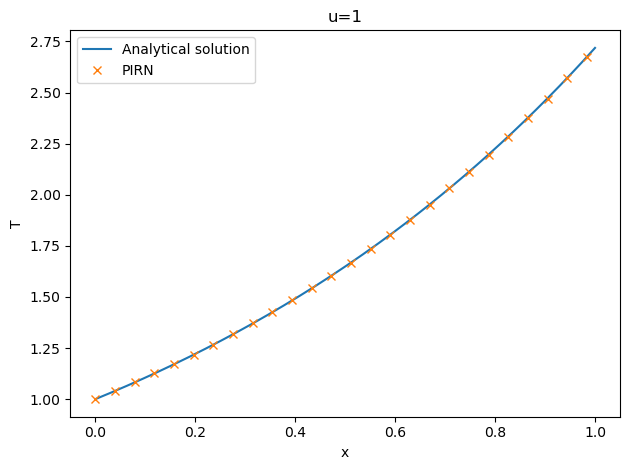

In [6]:
alpha = 1

x = np.linspace(0, 1, 128)

T = np.exp(u/alpha*x)

plt.figure(layout='tight')
plt.plot(x,T,label='Analytical solution')
plt.plot(x,T_test_np,'x',markevery=5, label='PIRN')
plt.xlabel('x')
plt.ylabel('T')
plt.legend()
plt.title(f'u={u}')
plt.savefig(f'u={u}.png')